# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="images/gradient_descent.png" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [1]:
! killall tensorboard
import os
os.system("tensorboard --logdir=./tensorboard_logs --port=7007 &");

tensorboard: no process found


In [2]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

We're using TF 1.13.1


Using TensorFlow backend.


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [3]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%time
sum_python(10**5)

CPU times: user 710 µs, sys: 205 µs, total: 915 µs
Wall time: 1.13 ms


333328333350000

# Tensoflow teaser

Doing the very same thing

In [5]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [6]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [7]:
# %%time
# actually executing
result.eval({N: 10**5})
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(s.run(result,{N: 10**5}))
    

333328333350000

In [8]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [9]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [10]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [11]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [12]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [13]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [14]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_predicted))

def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

Instructions for updating:
Use tf.cast instead.


In [15]:
writer.add_graph(mse.graph)
writer.flush()

In [16]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [17]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


In [19]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [20]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [21]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

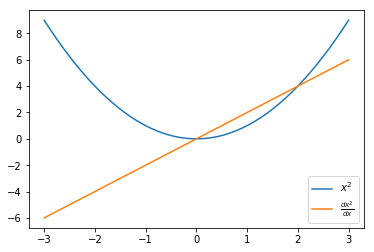

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [23]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

Instructions for updating:
Use tf.cast instead.


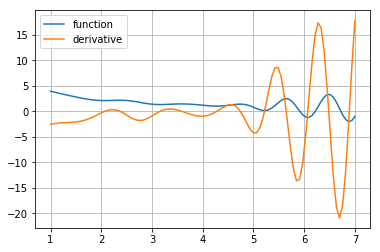

In [24]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [25]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

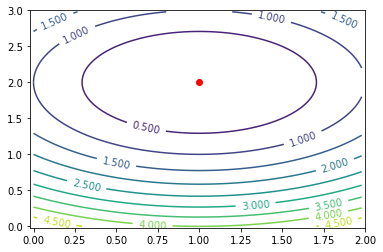

In [26]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [27]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABMSm1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADKZZYiE
AC///vau/MsrRwuVLh1Ze7NR8uhJcv2IMH1oAAADAADVayF8oYJVUBjg5Cl8UC950wnQObmxLpMS
eTd2N1o7ZvU7nZLqidQWs9IRqH4qZFuUNOvgrgAArGB7WlESNB735J/CfrjEy3i5zjzWx5r7oD4b
7vRGf5YZpSE2SfCltWRnqtLPBS3FxRjhpp/BEdar5txSfEu67R/ppgZwAi2i8ff512MwmU2ndVwZ
0/IypwbXeLiexIGKwjGLSLtuFQ6Y/OKysfXRdbpNhUrKtfRj7PsZ4sEuP5y4zl61S+z6VZzYCdA7
422O/g7ogLDysqUE24GpHGaJCX2wbS68ujTHQP6XxiSrNlnDwZHgbp5EeVkCuMJlhlbRejAAAW5E
i95ObYO5PsuB/yXJXIr296w2R4KtEWts2QxCeaTyILNtSj0FAa6n+Sm+7xuX2JriZx97d2rE/cAU
Qsh/+Ymis26EZW9S/cjgVqTEtyVS3CIlK2Ezdp99jK7/nX0GHUivuh8QdJ4bhVPEmo5B7TQYe9Nv
n+ebyMRkTx7hvj05vOEfMTes/dwPLUI91WSm8NQ11fuo1LrBS7pJhE73vxY1JjcZWnegaFLpPjAo
+BqceCYe5S3Av97ANnEBmzojm/SDmWarQluOhREg6XGZMu4a7snjhzyH4/KonlxVMyXTB8Ya3dGT
vrxM2T8GRxsFP+Ki2XIeafZhzaICPKgU1x2LYZqQc9bRDlrWDpuTNmcCbrO7DXBPWt4+vc4y9j4O
nmehjy3+29CwtFTKfeNDtJqpsgh9q2E1nXMB/b67agis4/9zgOkKQTrSKTL/ETxrRLU+M6bDF5Hw
Mkk0WQCW3/aB4rOdB/mjy0qnw4YqFkBjk8S3abocW1VP5xCX6kQu/S+pHlRN6K+k0MK67uDbQpak
Tg3oFCVnZYtI4fIdaw6N4CrUmzN3+T+U2DAvRHNB/dqFoMjErvCTrUOM5i6sgMFnPlzXuzglEx3r
tNS/ihpBKoZOTd1ViyEWuvp6CRVIYeDAf+u+GRvSyJD0uB2YFMYXUoJNAnwTcmSYyZTb5a4nxvDl
TOC8jlarLZ59F/D69SA66HYNiutMC2dploDTw52cruOXTwGu6T12mOk1kVNnQZriDnZ5c7I+N9HQ
a5ZPa57KaQLMuwNl5cmGiFp4HWwZktokWS6ak4lEXjSXXAiOxi7qBV49WigxIGR33VW8wRNdN3Dv
xgLQBmCInEdpSYWVa/7NpJBBH7cIb8ttDQIp2sXitLdMBUvDn63XlKb2/rqFXm4DJl2Woi2N3Ol0
XloGi675i1F6emt9/LLYQhVVKflHygiF0G+O9AVc2N/8DsTZJwFSpbyMG/Tst2fF3Nvy0sScZcTV
4KwHspWfq9YHyH4DdFDKVMWM1BaNsqek0yKv6K+jX0LsoL5Vr8KjZJ+RihiRjHS1R2byBoCqoi0P
rEI0pWor53obQeyY52ReSt/DWLCDSWlOgDG1tlMEleKmjysrE3aS59PR9hA8bdC7kPhnQ2tV0gSL
26GNMIDjsMBRW/3SowhuZbrNmTlxmBYV3hCRfvFysfKbzpg5k1qs459I2wsyLeKD4f8dcrcvCUg7
oa5G0vn+lToJZzDw2LcJk1HdFaIWUgC+woiUDqCzpfSNceg028zPwTXzCmJDKwJOvcBGFhwXmp4z
wi9Vr56d6r3XzmGGMexwaChFdcX3+RnqS6Fw1gLH+WHqMHBf88Ng0IQKG0O7KY1SfRF+RNUMAqRU
kBDnE+T7CsIWk+iAI54usYhOf3ZzwGkFSFlrZlHY9TRsZ15m0U1+pVprAMA4MsGtUeFB07K6uyAV
hk2T8AkUAGDGt4sbuxuZG7PcrbYaj8llFH8rxyn95ylTaRabhsAziWWC7fnI6NQXfyLMhYWCHoVI
r/iEsCfCLQj0d8obYU/KyGIJsSVNrRLeMmc00DlWyv/ZHiAjr7+xLTQlAoP7yT5iaVIfVSZ9+b+Z
WeCsaCl25Ys9K99tuM5jvlafGWZkFq1spKlVeojxVAAMpL8DFV2WUfJVGDMyE1ct046A1kPeiiRG
MndQwdVptxma2zKIvc2BRolDDSa8/LEF/DjiwriNa9wikvvaZARq+hDDcPuIcAKXtTPQq2ohiVuw
uarMf2mA9MkFrneFjnQM/0s+uU5jgquFlKj9kUf//Lh34l2T6bAG0DTd5uCP6eT02CYSX3QIXsLL
vy+OY3KnRyizGufKPRrjje2TuAigKjeqH7cYeCWz1iPtwQykwnhsY3/FF/HX986703GJVFl1p/be
f1tDkb3B0ULSUcf1tgTlTn8Myoh4A1wgOqpDaNHzXmTBg9pH/cMjBYQQuTtpURQKVbwIHZWR0Uyy
u1MxcZgaHnIFqJXEdLsje/wFD8aC1GUFwM6/CSYeMQWp3u2I+3S4yNoI3fHZfah0u4c1vvNbiEcK
Nz6vsG6t0IfQVVeKqAoiOUqHAsu3ZOaFvOwn5EIaLhRH1bjVxyA4jOYhY8mJ6SrGdsncxO1mEKJp
VZpQgC5hyDeyoH+/ZrHoyH01UpsZxzfvl2U6PuiBIVCWlKAUfiiMyg9tS1LiqfTp3pNXVZkOglxU
AVXLxhAvM7ve5ct6bpU3I6pDH2Liipvmm6CmJ3v7FLEMFSAH/fleCoqOjQA3ybCj248xQb5sNOJN
DBHEnP5YJ4jTDtzYbvfyC24/Wz9K1LK057yAuT51mRhoEj3ok2srA2J0BF5mI/th3bLiMXqrnoFv
F7Jbp85SUJzo/otG3/hBE2m5kolxd9TFo2JMmdD15GataI/wfXGq2K2K1KbW8DrtvpHzbROuO3e3
AQB0lsTn1SgiUtDwLeQEhMGpdUuL6vUzrtIR/MfSIDUT444AOMTmTBjCApv5r3nbK+LIB53KuKMh
E4P1gWIqhgveyuzjO5LMB